# To do

- One hot encode data (Complete)
- Rework windowing function (Complete)
- Fix Neural Network to work with OHE Data (Complete)
- Include SMAPE in Neural Network (Complete)
- Work on forecasting portion
- Expand dataset so that it includes all stores and items (500 trendlines)
- Optimize neural network. Consider using Conv1D layer?

# Introduction

This is a demand forecaster for the kaggle competition at https://www.kaggle.com/c/demand-forecasting-kernels-only using a LSTM neural network

In [1]:
## Imports

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import OneHotEncoder

import torch as torch
import torch.nn as nn

In [2]:
## Import data

path_in = './data/'
train_cols = ['date', 'store', 'item', 'sales']
train_dtypes = {'date': 'str', 'store': 'int', 'item': 'int', 'sales': 'int'}
parse_dates = ['date']

test_cols = ['date', 'store', 'item']
test_dtypes = {'date': 'str', 'store': 'int', 'item': 'int'}


train = pd.read_csv(path_in + 'train.csv', dtype = train_dtypes, parse_dates = parse_dates)
test = pd.read_csv(path_in + 'test.csv', dtype = test_dtypes, parse_dates = parse_dates)

In [3]:
train.sample(10)

,date,store,item,sales
637344,2013-03-12,10,35,60
633834,2013-08-01,8,35,72
39216,2015-05-21,2,3,54
672624,2014-10-19,9,37,28
615362,2013-01-01,8,34,16
731654,2016-06-08,1,41,22
759334,2017-03-25,6,42,31
903113,2015-12-06,5,50,55
783488,2013-05-15,10,43,62
604842,2014-03-13,2,34,34


So there are 10 stores with 50 different products. The sales for each item range between 0 and 231, but they are mainly around the 30-70 range. There is five years worth of sales data (2013-2017) to train on and the goal is the predict the sales for the next 3 months.

In [4]:
sample = train.loc[train['store'] == 1].loc[train['item'] == 1]

In [5]:
sample

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
1821,2017-12-27,1,1,14
1822,2017-12-28,1,1,19
1823,2017-12-29,1,1,15
1824,2017-12-30,1,1,27


## Preprocessing
Here we create a windowed dataset to preprocess the data

In [6]:
# Include other date information to be processed
train['day_of_week'] = train['date'].dt.dayofweek
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year - 2013 # Subtract earliest year to help normalize this information

In [7]:
# One Hot Encode data
columns_OHE = train.columns[((train.columns != 'sales') & (train.columns != 'date')) & (train.columns != 'year')]
train_OHE = pd.get_dummies(train, columns = columns_OHE)

In [8]:
OHE_cols = train_OHE.columns

In [9]:
# Take a sample of only one item in one store to test neural network
sample = train_OHE.loc[(train['store'] == 5) & (train['item'] == 1)]

In [10]:
def create_data_windows(df, width):
    """
    Function: Takes in the DataFrame, df, and splits it into rolling windows of size width to be used in a neural network.
    It outputs a dataframe and a target dataframe, which is the sales number to be predicted. The other information such
    as year, day of the week, are all taken from the target.
    Inputs: df - dataframe with columns [date, store, item, sales]
            width - the with of the window including the last sales data which will be the target
    Outputs: df_windowed - dataframe with the day of the week of the last day of the window, the store, and item numbers
                            along with the windowed sales data
             df_target - dataframe that contains the target date and target sales
    """
    # Retrieve column names that are not date nor sales
    other_columns = df.columns[((df.columns != 'sales') & (df.columns != 'date'))]
    
    # Initalize output datasets
    windowed_data = np.empty([len(df)-width+1, width - 1])
    df = df.reset_index(drop = True)
    
    # Create windows. E.g. [1, 2, 3, 4, 5, 6, 7] -> [[1,2,3,4], [2,3,4,5], [3,4,5,6]]
    # Also creates targets which would be [[5], [6], [7]] in the above case
    for i in range(len(df)-width+1):
        windowed_data[i] = list(df.iloc[i:i+width-1]['sales'])
        
        
    # Create a DataFrame to contain the windowed data
    windowed_columns = list(map(str,(range(1,width))))
    
    df_temp = pd.DataFrame(data = windowed_data, 
                               columns = windowed_columns,
                               dtype = 'int')
    # Create a DataFrame containing store, year, etc. information and combine with windowed data
    df_other = df.loc[width-1::, other_columns].reset_index(drop = True)
    
    df_windowed = pd.concat([df_temp, df_other], axis = 1)
    
    # Create target dataset
    df_target = pd.DataFrame(data = df.loc[width-1::, ['date', 'sales']]).reset_index(drop = True)
        
    return df_windowed, df_target

In [11]:
window_size = 30
df, df_target = create_data_windows(sample, window_size + 1)

In [12]:
df

,1,2,3,4,5,6,7,8,9,10,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,11,9,12,8,13,15,6,11,13,9,...,0,0,0,0,0,0,0,0,0,0
1,9,12,8,13,15,6,11,13,9,9,...,0,0,0,0,0,0,0,0,0,0
2,12,8,13,15,6,11,13,9,9,8,...,0,0,0,0,0,0,0,0,0,0
3,8,13,15,6,11,13,9,9,8,22,...,0,0,0,0,0,0,0,0,0,0
4,13,15,6,11,13,9,9,8,22,8,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1791,13,16,23,27,9,20,14,9,9,18,...,0,0,0,0,0,0,0,0,0,1
1792,16,23,27,9,20,14,9,9,18,13,...,0,0,0,0,0,0,0,0,0,1
1793,23,27,9,20,14,9,9,18,13,15,...,0,0,0,0,0,0,0,0,0,1
1794,27,9,20,14,9,9,18,13,15,24,...,0,0,0,0,0,0,0,0,0,1


In [13]:
df_target

,date,sales
0,2013-01-31,6
1,2013-02-01,6
2,2013-02-02,20
3,2013-02-03,13
4,2013-02-04,12
...,...,...
1791,2017-12-27,15
1792,2017-12-28,13
1793,2017-12-29,18
1794,2017-12-30,19


In [14]:
# Train-test split
sample_train_df, sample_train_target = df.iloc[:-365], df_target.iloc[:-365]
sample_val_df, sample_val_target = df.iloc[-365::], df_target.iloc[-365::]

In [15]:
sample_train_df

,1,2,3,4,5,6,7,8,9,10,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,11,9,12,8,13,15,6,11,13,9,...,0,0,0,0,0,0,0,0,0,0
1,9,12,8,13,15,6,11,13,9,9,...,0,0,0,0,0,0,0,0,0,0
2,12,8,13,15,6,11,13,9,9,8,...,0,0,0,0,0,0,0,0,0,0
3,8,13,15,6,11,13,9,9,8,22,...,0,0,0,0,0,0,0,0,0,0
4,13,15,6,11,13,9,9,8,22,8,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1426,16,22,15,18,6,19,15,14,21,13,...,0,0,0,0,0,0,0,0,0,1
1427,22,15,18,6,19,15,14,21,13,17,...,0,0,0,0,0,0,0,0,0,1
1428,15,18,6,19,15,14,21,13,17,9,...,0,0,0,0,0,0,0,0,0,1
1429,18,6,19,15,14,21,13,17,9,17,...,0,0,0,0,0,0,0,0,0,1


In [16]:
sample_train_target

,date,sales
0,2013-01-31,6
1,2013-02-01,6
2,2013-02-02,20
3,2013-02-03,13
4,2013-02-04,12
...,...,...
1426,2016-12-27,9
1427,2016-12-28,6
1428,2016-12-29,23
1429,2016-12-30,16


Turn dataframes into tensors to prepare them to be fed into neural network in pytorch

In [17]:
training_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(np.array(sample_train_df)), torch.FloatTensor(np.array(sample_train_target['sales'])))
validation_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(np.array(sample_val_df)), torch.FloatTensor(np.array(sample_val_target['sales'])))

# Neural Network

Initalize Neural Network

In [18]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.constant_(m.bias,0)
        
def SMAPE(y_true, y_pred):
    """ Returns the standard mean absolute percent error in %
    """
    return np.mean(200*np.abs(y_pred - y_true)/(np.abs(y_pred)+np.abs(y_true)))
        
class Net(nn.Module):
    def __init__(self, num_cols, window_length, n_hidden_1, n_hidden_2, D_out, p=0.0):
        super().__init__()
        
        # Subtract 1 because the window includes the target
        self.window_length = window_length
        self.num_cols = num_cols
        
        self.lstm1 = nn.LSTM(1, n_hidden_1, bidirectional = False, batch_first = True)
        
        self.fc1 = nn.Linear(n_hidden_1 + num_cols - self.window_length, n_hidden_2)
        # self.drop1 = nn.Dropout(p=p)
        self.relu1 = nn.ReLU()
        
        self.fc2 = nn.Linear(n_hidden_2, D_out)
        self.out_act = nn.ReLU()
        
    def forward(self, x):
        # Split input tensor. x_seq will be fed into the lstm.
        x_seq, x_info = x[:,:self.window_length], x[:,self.window_length:]
        
        # LSTM layer
        x_seq = torch.unsqueeze(x_seq, 2)
        lstm_out, (h, c) = self.lstm1(x_seq)
        
        # Combine the extra info to the lstm results using the output of the last lstm neuron
        lstm_output = torch.squeeze(lstm_out[:,1,:])
        
        combined_out = torch.cat([lstm_output, x_info], 1)
        
        # Fully connected layer
        fc1_out = self.fc1(combined_out)
        fc1_out = self.relu1(fc1_out)
        
        # Output layer
        y = self.out_act(self.fc2(fc1_out))
        
        # Squeeze to remove extra dimensions of size 1
        return torch.squeeze(y)

In [19]:
def train_model(data_set, model, criterion, train_loader, validation_loader, optimizer, epochs=10):
    model.train()
    loss_accuracy = {'training_loss':[], 'validation_loss':[],'validation_smape':[], 'validation_precision':[], 'validation_recall':[]}
    
    training_size = (len(list(train_loader))-1)*len(list(train_loader)[0][0]) + len(list(train_loader)[-1][0])
    
    for epoch in range(epochs):
        #clear_output(wait=True)
        print("Epoch {} / {}\n=============".format(epoch+1, epochs))
            
        train_smape_sum = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            ## Forward pass
            yhat = model(x)
            ## Compute loss
            train_loss = criterion(yhat, y)
            ## Compute gradient in backward pass
            train_loss.backward()
            ## Update weights
            optimizer.step()
            
            train_smape_sum += SMAPE(y.numpy(), yhat.detach().numpy()) * len(x)
            
            loss_accuracy['training_loss'].append(train_loss.item())
         
        ## Compute validation accuracy
        model.eval()
        correct = 0
        for x, y in validation_loader:
            yhat = net(x)
            val_loss = criterion(yhat, y)                     
            val_smape = SMAPE(y.numpy(), yhat.detach().numpy())
            
        # Calculate loss values
        train_smape = train_smape_sum / training_size
        
        loss_accuracy['validation_loss'].append(val_loss.item())
        loss_accuracy['validation_smape'].append(val_smape)
        
        
        ## Print training loss and accuracy, and validation accuracy
        
        print("Training mean squared error: {:.3f} | Training SMAPE: {:.2f}\nValidation mean squared error: {:.3f} | Validation SMAPE: {:.2f}".format(
            train_loss.item(), train_smape, val_loss.item(), val_smape))
        
        model.train()
        
        ## Add precision and recall
        
    print("Training complete!")
                
    return loss_accuracy

In [20]:
epochs = 10
learning_rate = 0.0005

## Network dimensions
num_cols = len(sample_train_df.columns)
n_hidden_1 = 32
n_hidden_2 = 32
D_out = 1
batch_size = 64
reg_lambda = 0
momentum_coef = 0.9
dropout_percent = 0.0

## Load data
train_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=len(validation_dataset), shuffle=False)

## Initialize model
net = Net(num_cols, window_size, n_hidden_1, n_hidden_2, D_out, p = dropout_percent)
net.apply(weights_init)


optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay = reg_lambda)
criterion = nn.MSELoss()

In [21]:
epochs = 10
## Train the model
loss_accuracy = train_model(training_dataset, net, criterion, train_loader, validation_loader, optimizer, epochs=epochs)

Epoch 1 / 10
Training mean squared error: 228.025 | Training SMAPE: 172.08
Validation mean squared error: 326.404 | Validation SMAPE: 161.98
Epoch 2 / 10
Training mean squared error: 227.548 | Training SMAPE: 148.21
Validation mean squared error: 282.595 | Validation SMAPE: 138.78
Epoch 3 / 10
Training mean squared error: 169.989 | Training SMAPE: 118.01
Validation mean squared error: 222.062 | Validation SMAPE: 108.73
Epoch 4 / 10
Training mean squared error: 52.884 | Training SMAPE: 79.98
Validation mean squared error: 142.707 | Validation SMAPE: 71.20
Epoch 5 / 10
Training mean squared error: 33.718 | Training SMAPE: 45.94
Validation mean squared error: 73.910 | Validation SMAPE: 41.33
Epoch 6 / 10
Training mean squared error: 17.660 | Training SMAPE: 28.94
Validation mean squared error: 41.809 | Validation SMAPE: 29.04
Epoch 7 / 10
Training mean squared error: 28.254 | Training SMAPE: 26.63
Validation mean squared error: 35.576 | Validation SMAPE: 26.73
Epoch 8 / 10
Training mean s

Text(0, 0.5, 'Validation SMAPE [%]')

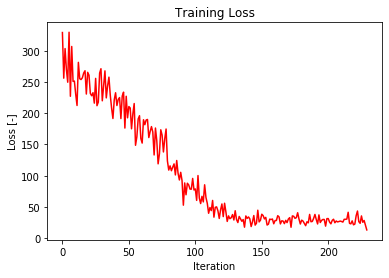

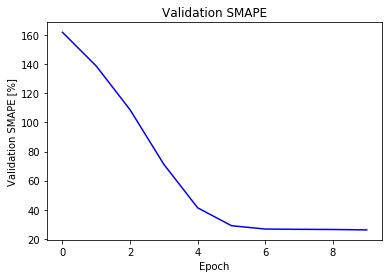

In [22]:
## Plots
fig = plt.figure(1)
plt.plot(loss_accuracy['training_loss'], color="red")
plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss [-]")

fig = plt.figure(2)
plt.plot(loss_accuracy['validation_smape'], color="blue")
plt.title("Validation SMAPE")
plt.xlabel("Epoch")
plt.ylabel("Validation SMAPE [%]")

In [23]:
# sample['date'] + datetime.timedelta(days = 1)

# Forecasting

In [24]:
d = {'sales': [16], 'date': ['2018-12-03'], 'item': [1], 'store': [13]}

In [25]:
d_test = pd.DataFrame(d)

In [32]:
d_test['date'] = pd.to_datetime(d_test['date'])

In [33]:
d_test['date']

0   2018-12-03
Name: date, dtype: datetime64[ns]

In [35]:
d_test_OHE = pd.get_dummies(d_test, columns = columns_OHE)

In [36]:
d_test_OHE = d_test_OHE.reindex(columns = OHE_cols).fillna(0)

In [37]:
d_test_OHE

,date,sales,year,store_1,store_2,store_3,store_4,store_5,store_6,store_7,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2018-12-03,16,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [38]:
start_date = pd.to_datetime('2018-01-01')
end_date = pd.to_datetime('2018-03-31')

first_sales = train.loc[(train['date'] >= (start_date - datetime.timedelta(days = window_size))) & (train['store'] == 5)
        & (train['item'] == 1),'sales']

In [ ]:
train.loc[(train['store'] == 5) & (train['item'] == 1)].iloc[-30::]

In [ ]:
sample_val_target

In [102]:
start_date = pd.to_datetime('2018-01-01')
end_date = pd.to_datetime('2018-03-31')
dates = pd.date_range(start = start_date, end = end_date, freq = 'D')
store_num = 1
item_num = 1

current_date = start_date
sales_seq = train.loc[(train['date'] >= (start_date - datetime.timedelta(days = window_size))) & (train['store'] == 5)
                      & (train['item'] == 1),'sales']

predictions = pd.DateFrame({'date': [], 'sales': []})

for i in range(len(dates)):
    # Initialize store, date, and item data inputs to neural network
    df_misc_info = {'date': current_date, 'item': item_num, 'store': store_num}
    df_misc_info['date'] = pd.to_datetime(df_temp['date'], errors = 'coerce')
    df_misc_info['day_of_week'] = df_temp['date'].dayofweek
    df_misc_info['month'] = df_temp['date'].month
    df_misc_info['year'] = df_temp['date'].year
    
    # Initialize sequential data
    windowed_columns = list(map(str,(range(1,width))))
    df_seq = pd.DataFrame(data = sales_seq, 
                               columns = windowed_columns,
                               dtype = 'int')
    
    # Combine input data and ensure columns match
    df_input = pd.concat([df_seq, df_misc_info], axis = 1)
    df_input_OHE = pd.get_dummies(d_test, columns = columns_OHE)
    df_input_OHE = d_input_OHE.reindex(columns = OHE_cols).fillna(0)
    
    # Forecast sales for next day
    x = Variable(torch.LongTensor(np.array(df_input_OHE)))
    y = net(x)
    
    # Append date and data
    
    # Update sequence and date

    
    

In [ ]:
df_temp['date'] = pd.to_datetime(df_temp['date'])
df_temp['day_of_week'] = df_temp['date'].dt.dayofweek

In [ ]:
pd.date_range('2018-01-01', freq = 'D')

In [ ]:
pd.Series('2018-01-01').dt.to_pydatetime()

In [46]:
str(start_date)

'2018-03-31 00:00:00'

In [56]:
train.loc[(train['date'] >= (start_date - datetime.timedelta(days = window_size))) & (train['store'] == 5) & (train['item'] == 1),'sales']

ValueError: Lengths must match

In [57]:
start_date - datetime.timedelta(days = window_size)

DatetimeIndex(['2018-03-01'], dtype='datetime64[ns]', freq=None)

In [60]:
(train['date'] >= (start_date - datetime.timedelta(days = window_size)))

ValueError: Lengths must match

In [78]:
df_temp

{'date': Timestamp('2018-03-31 00:00:00'),
 'item': 1,
 'store': 1,
 'day_of_week': 5,
 'month': 3,
 'year': 2018}

In [79]:
OHE_cols

Index(['date', 'sales', 'year', 'store_1', 'store_2', 'store_3', 'store_4',
       'store_5', 'store_6', 'store_7', 'store_8', 'store_9', 'store_10',
       'item_1', 'item_2', 'item_3', 'item_4', 'item_5', 'item_6', 'item_7',
       'item_8', 'item_9', 'item_10', 'item_11', 'item_12', 'item_13',
       'item_14', 'item_15', 'item_16', 'item_17', 'item_18', 'item_19',
       'item_20', 'item_21', 'item_22', 'item_23', 'item_24', 'item_25',
       'item_26', 'item_27', 'item_28', 'item_29', 'item_30', 'item_31',
       'item_32', 'item_33', 'item_34', 'item_35', 'item_36', 'item_37',
       'item_38', 'item_39', 'item_40', 'item_41', 'item_42', 'item_43',
       'item_44', 'item_45', 'item_46', 'item_47', 'item_48', 'item_49',
       'item_50', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2',
       'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_

In [104]:
len(first_sales)

30

In [93]:
start_date + datetime.timedelta(days = window_size)

Timestamp('2018-04-30 00:00:00')

In [83]:
window_size

30

In [84]:
datetime.timedelta(days = window_size)

datetime.timedelta(days=30)

In [94]:
start_date

Timestamp('2018-03-31 00:00:00')

In [101]:
test.loc[(test['store'] == 1) & (test['item'] == 1), 'date']

0    2018-01-01
1    2018-01-02
2    2018-01-03
3    2018-01-04
4    2018-01-05
        ...    
85   2018-03-27
86   2018-03-28
87   2018-03-29
88   2018-03-30
89   2018-03-31
Name: date, Length: 90, dtype: datetime64[ns]

In [105]:
len(dates)

90